# 墨尔本大学研究项目判断模型

有几个学者想组队研究项目，申请学校的补助款。学校依据团队资质，成员资料判断给不给补助款。

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
application=pd.read_csv('unimelb_training.csv')

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (90,105,119,120,123,124,132,134,135,138,139,147,149,150,153,154,162,164,165,168,169,177,179,183,184,192,194,198,199,207,209,213,214,224,237,239,244) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
application.head()

,Grant.Application.ID,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,Start.date,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,...,Dept.No..15,Faculty.No..15,With.PHD.15,No..of.Years.in.Uni.at.Time.of.Grant.15,Number.of.Successful.Grant.15,Number.of.Unsuccessful.Grant.15,A..15,A.15,B.15,C.15
0,1,1,NaN,NaN,A,2008/11/5,280199.0,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,2B,10A,B,2011/11/5,280103.0,30.0,280106.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,29A,10B,A,2014/11/5,321004.0,60.0,321216.0,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,40D,10B,C,2015/11/5,270602.0,50.0,320602.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,59C,10A,A,2016/11/5,260500.0,34.0,280000.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
list(application.columns)[4]

'Contract.Value.Band...see.note.A'

In [6]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Columns: 251 entries, Grant.Application.ID to C.15
dtypes: float64(179), int64(2), object(70)
memory usage: 16.7+ MB


数据集维度过高，我们将团队数据简化为：成员人数，拥有PHD人数，平均在校时间，平均年龄，平均成功研究项目数，平均不成功研究项目数，平均各类期刊发表文章数。

统计成员人数

In [7]:
columns=['Person.ID.'+str(n) for n in range(1,16)]
num=application[columns].notnull().sum(axis=1)
application['NumofP']=num

统计PHD人数

In [8]:
columns=['With.PHD.'+str(n) for n in range(1,16)]   
num=application[columns].notnull().sum(axis=1)
application['NumofPHD']=num

统计历史成功申请补助款次数

In [9]:
columns=['Number.of.Successful.Grant.'+str(n) for n in range(1,16)]
num=application[columns].fillna(0).sum(axis=1)
application['NumofS']=num

统计历史不成功申请补助款次数

In [10]:
columns=['Number.of.Unsuccessful.Grant.'+str(n) for n in range(1,16)]
num=application[columns].fillna(0).sum(axis=1)
application['NumofUS']=num

统计团队A\*类文献发表数

In [11]:
columns=['A..'+str(n) for n in range(1,16)]
    
num=application[columns].fillna(0).sum(axis=1)

application['NumofA.']=num

统计团队A类文献发表数

In [12]:
columns=['A.'+str(n) for n in range(1,16)]
num=application[columns].fillna(0).sum(axis=1)
application['NumofA']=num

统计团队B类文献发表数

In [13]:
columns=['B.'+str(n) for n in range(1,16)]
num=application[columns].fillna(0).sum(axis=1)
application['NumofB']=num

统计团队C类文献发表数

In [14]:
columns=['C.'+str(n) for n in range(1,16)]
num=application[columns].fillna(0).sum(axis=1)
application['NumofC']=num

在此先删除开始日期为1930年的项目，因为怀疑这是个录入错误

In [15]:
date=pd.to_datetime(application['Start.date'])
index=date[date.dt.year==1930].index
application.drop(index)

,Grant.Application.ID,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,Start.date,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,...,B.15,C.15,NumofP,NumofPHD,NumofS,NumofUS,NumofA.,NumofA,NumofB,NumofC
0,1,1,NaN,NaN,A,2008/11/5,280199.0,100.0,0.0,0.0,...,NaN,NaN,1,0,0.0,0.0,4.0,2.0,0.0,0.0
1,2,1,2B,10A,B,2011/11/5,280103.0,30.0,280106.0,30.0,...,NaN,NaN,1,1,0.0,0.0,6.0,12.0,2.0,2.0
2,3,1,29A,10B,A,2014/11/5,321004.0,60.0,321216.0,40.0,...,NaN,NaN,4,2,0.0,0.0,7.0,20.0,20.0,7.0
3,4,1,40D,10B,C,2015/11/5,270602.0,50.0,320602.0,50.0,...,NaN,NaN,2,2,0.0,0.0,0.0,3.0,13.0,3.0
4,5,0,59C,10A,A,2016/11/5,260500.0,34.0,280000.0,33.0,...,NaN,NaN,1,1,0.0,0.0,3.0,0.0,1.0,0.0
5,6,1,4D,10A,NaN,2019/11/5,321204.0,100.0,0.0,0.0,...,NaN,NaN,1,1,2.0,0.0,7.0,27.0,27.0,6.0
6,7,0,2B,10A,NaN,2019/11/5,270708.0,50.0,270203.0,30.0,...,NaN,NaN,3,2,0.0,1.0,8.0,12.0,14.0,4.0
7,8,0,28D,30B,A,2019/11/5,321405.0,100.0,0.0,0.0,...,NaN,NaN,2,0,0.0,3.0,0.0,0.0,0.0,0.0
8,9,1,2B,10A,H,2019/11/5,260108.0,50.0,260109.0,50.0,...,NaN,NaN,2,2,2.0,1.0,8.0,1.0,11.0,0.0
9,10,1,2B,10A,NaN,2019/11/5,270708.0,40.0,270704.0,30.0,...,NaN,NaN,1,0,0.0,0.0,1.0,0.0,0.0,0.0


计算成员平均年龄

In [16]:
import numpy as np
columns=['Year.of.Birth.'+str(n) for n in range(1,16)]
    
num=application[columns].fillna(0).sum(axis=1)
sy=pd.to_datetime(application['Start.date']).dt.year

age=(np.array(application['NumofP'])*np.array(sy)-np.array(num))/np.array(application['NumofP'])
application['age']=age

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


计算成员平均在校时间

In [17]:
columns=['No..of.Years.in.Uni.at.Time.of.Grant.'+str(n) for n in range(1,16)]
    

yearinuni=application[columns]
yearinuni=yearinuni.fillna(0)
yearinuni=yearinuni.replace('>10 to 15',12.5)
yearinuni=yearinuni.replace('>5 to 10',7.5)
yearinuni=yearinuni.replace('>=0 to 5',2.5)
yearinuni=yearinuni.replace('Less than 0',0)
yearinuni=yearinuni.replace('more than 15',15)

num=yearinuni.sum(axis=1)
age=np.array(num)/np.array(application['NumofP'])
application['Year in uni']=age

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [18]:
num=yearinuni.sum(axis=1)
age=np.array(num)/np.array(application['NumofP'])
application['Year in uni']=age

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


清理不用的特征

In [19]:
application=application.drop(columns=['Grant.Application.ID',  'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band...see.note.A', 'Start.date', 'RFCD.Code.1', 'RFCD.Percentage.1', 'RFCD.Code.2', 'RFCD.Percentage.2', 'RFCD.Code.3', 'RFCD.Percentage.3', 'RFCD.Code.4', 'RFCD.Percentage.4', 'RFCD.Code.5', 'RFCD.Percentage.5', 'SEO.Code.1', 'SEO.Percentage.1', 'SEO.Code.2', 'SEO.Percentage.2', 'SEO.Code.3', 'SEO.Percentage.3', 'SEO.Code.4', 'SEO.Percentage.4', 'SEO.Code.5', 'SEO.Percentage.5', 'Person.ID.1', 'Role.1', 'Year.of.Birth.1', 'Country.of.Birth.1', 'Home.Language.1', 'Dept.No..1', 'Faculty.No..1', 'With.PHD.1', 'No..of.Years.in.Uni.at.Time.of.Grant.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1', 'A..1', 'A.1', 'B.1', 'C.1', 'Person.ID.2', 'Role.2', 'Year.of.Birth.2', 'Country.of.Birth.2', 'Home.Language.2', 'Dept.No..2', 'Faculty.No..2', 'With.PHD.2', 'No..of.Years.in.Uni.at.Time.of.Grant.2', 'Number.of.Successful.Grant.2', 'Number.of.Unsuccessful.Grant.2', 'A..2', 'A.2', 'B.2', 'C.2', 'Person.ID.3', 'Role.3', 'Year.of.Birth.3', 'Country.of.Birth.3', 'Home.Language.3', 'Dept.No..3', 'Faculty.No..3', 'With.PHD.3', 'No..of.Years.in.Uni.at.Time.of.Grant.3', 'Number.of.Successful.Grant.3', 'Number.of.Unsuccessful.Grant.3', 'A..3', 'A.3', 'B.3', 'C.3', 'Person.ID.4', 'Role.4', 'Year.of.Birth.4', 'Country.of.Birth.4', 'Home.Language.4', 'Dept.No..4', 'Faculty.No..4', 'With.PHD.4', 'No..of.Years.in.Uni.at.Time.of.Grant.4', 'Number.of.Successful.Grant.4', 'Number.of.Unsuccessful.Grant.4', 'A..4', 'A.4', 'B.4', 'C.4', 'Person.ID.5', 'Role.5', 'Year.of.Birth.5', 'Country.of.Birth.5', 'Home.Language.5', 'Dept.No..5', 'Faculty.No..5', 'With.PHD.5', 'No..of.Years.in.Uni.at.Time.of.Grant.5', 'Number.of.Successful.Grant.5', 'Number.of.Unsuccessful.Grant.5', 'A..5', 'A.5', 'B.5', 'C.5', 'Person.ID.6', 'Role.6', 'Year.of.Birth.6', 'Country.of.Birth.6', 'Home.Language.6', 'Dept.No..6', 'Faculty.No..6', 'With.PHD.6', 'No..of.Years.in.Uni.at.Time.of.Grant.6', 'Number.of.Successful.Grant.6', 'Number.of.Unsuccessful.Grant.6', 'A..6', 'A.6', 'B.6', 'C.6', 'Person.ID.7', 'Role.7', 'Year.of.Birth.7', 'Country.of.Birth.7', 'Home.Language.7', 'Dept.No..7', 'Faculty.No..7', 'With.PHD.7', 'No..of.Years.in.Uni.at.Time.of.Grant.7', 'Number.of.Successful.Grant.7', 'Number.of.Unsuccessful.Grant.7', 'A..7', 'A.7', 'B.7', 'C.7', 'Person.ID.8', 'Role.8', 'Year.of.Birth.8', 'Country.of.Birth.8', 'Home.Language.8', 'Dept.No..8', 'Faculty.No..8', 'With.PHD.8', 'No..of.Years.in.Uni.at.Time.of.Grant.8', 'Number.of.Successful.Grant.8', 'Number.of.Unsuccessful.Grant.8', 'A..8', 'A.8', 'B.8', 'C.8', 'Person.ID.9', 'Role.9', 'Year.of.Birth.9', 'Country.of.Birth.9', 'Home.Language.9', 'Dept.No..9', 'Faculty.No..9', 'With.PHD.9', 'No..of.Years.in.Uni.at.Time.of.Grant.9', 'Number.of.Successful.Grant.9', 'Number.of.Unsuccessful.Grant.9', 'A..9', 'A.9', 'B.9', 'C.9', 'Person.ID.10', 'Role.10', 'Year.of.Birth.10', 'Country.of.Birth.10', 'Home.Language.10', 'Dept.No..10', 'Faculty.No..10', 'With.PHD.10', 'No..of.Years.in.Uni.at.Time.of.Grant.10', 'Number.of.Successful.Grant.10', 'Number.of.Unsuccessful.Grant.10', 'A..10', 'A.10', 'B.10', 'C.10', 'Person.ID.11', 'Role.11', 'Year.of.Birth.11', 'Country.of.Birth.11', 'Home.Language.11', 'Dept.No..11', 'Faculty.No..11', 'With.PHD.11', 'No..of.Years.in.Uni.at.Time.of.Grant.11', 'Number.of.Successful.Grant.11', 'Number.of.Unsuccessful.Grant.11', 'A..11', 'A.11', 'B.11', 'C.11', 'Person.ID.12', 'Role.12', 'Year.of.Birth.12', 'Country.of.Birth.12', 'Home.Language.12', 'Dept.No..12', 'Faculty.No..12', 'With.PHD.12', 'No..of.Years.in.Uni.at.Time.of.Grant.12', 'Number.of.Successful.Grant.12', 'Number.of.Unsuccessful.Grant.12', 'A..12', 'A.12', 'B.12', 'C.12', 'Person.ID.13', 'Role.13', 'Year.of.Birth.13', 'Country.of.Birth.13', 'Home.Language.13', 'Dept.No..13', 'Faculty.No..13', 'With.PHD.13', 'No..of.Years.in.Uni.at.Time.of.Grant.13', 'Number.of.Successful.Grant.13', 'Number.of.Unsuccessful.Grant.13', 'A..13', 'A.13', 'B.13', 'C.13', 'Person.ID.14', 'Role.14', 'Year.of.Birth.14', 'Country.of.Birth.14', 'Home.Language.14', 'Dept.No..14', 'Faculty.No..14', 'With.PHD.14', 'No..of.Years.in.Uni.at.Time.of.Grant.14', 'Number.of.Successful.Grant.14', 'Number.of.Unsuccessful.Grant.14', 'A..14', 'A.14', 'B.14', 'C.14', 'Person.ID.15', 'Role.15', 'Year.of.Birth.15', 'Country.of.Birth.15', 'Home.Language.15', 'Dept.No..15', 'Faculty.No..15', 'With.PHD.15', 'No..of.Years.in.Uni.at.Time.of.Grant.15', 'Number.of.Successful.Grant.15', 'Number.of.Unsuccessful.Grant.15', 'A..15', 'A.15', 'B.15', 'C.15'])

In [20]:
application.describe()

,Grant.Status,NumofP,NumofPHD,NumofS,NumofUS,NumofA.,NumofA,NumofB,NumofC,age,Year in uni
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8240.000000,8240.000000
mean,0.458429,1.496899,0.917432,1.731626,3.061667,5.165136,7.189596,5.592444,3.017800,48.490444,5.418684
std,0.498297,1.042395,0.897762,2.326951,4.491482,11.967629,12.348254,8.592110,5.940251,40.724202,4.618333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-100.071429,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,2.500000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,51.000000,3.750000
75%,1.000000,2.000000,1.000000,2.000000,4.000000,6.000000,8.000000,7.000000,3.000000,60.000000,7.500000
max,1.000000,14.000000,12.000000,44.000000,46.000000,262.000000,154.000000,117.000000,78.000000,2013.000000,15.000000


去除错误的平均年龄

In [21]:
application=application[application['age']>0]
application=application[application['age']<100]

计算团队成员PHD占比

In [22]:
application['PHDper']=np.array(application['NumofPHD'])/np.array(application['NumofP'])

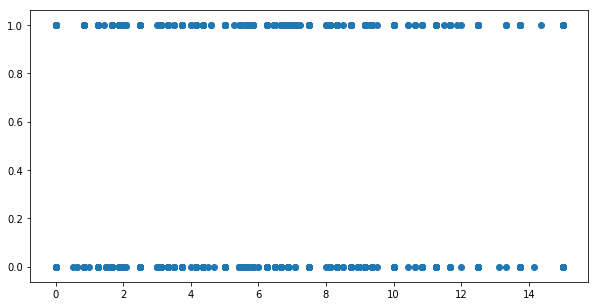

In [23]:
plt.figure(figsize=(10,5))
plt.scatter(application['Year in uni'],application['Grant.Status'])
plt.show()

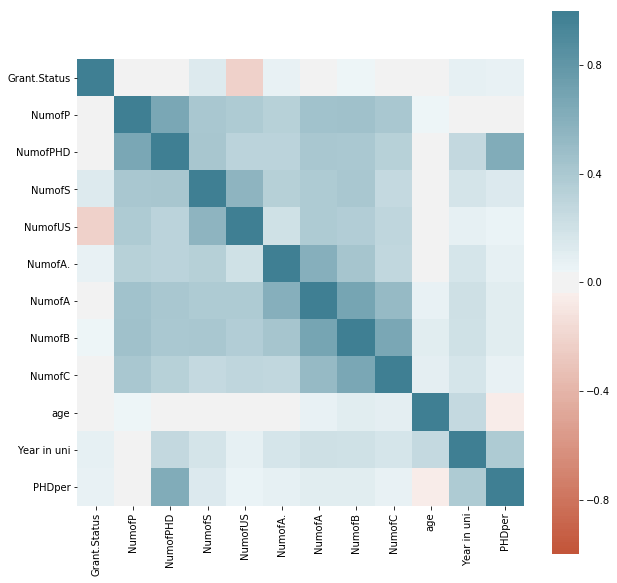

In [24]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(application.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
plt.show()

In [25]:
application=application.drop(columns=['NumofPHD'])

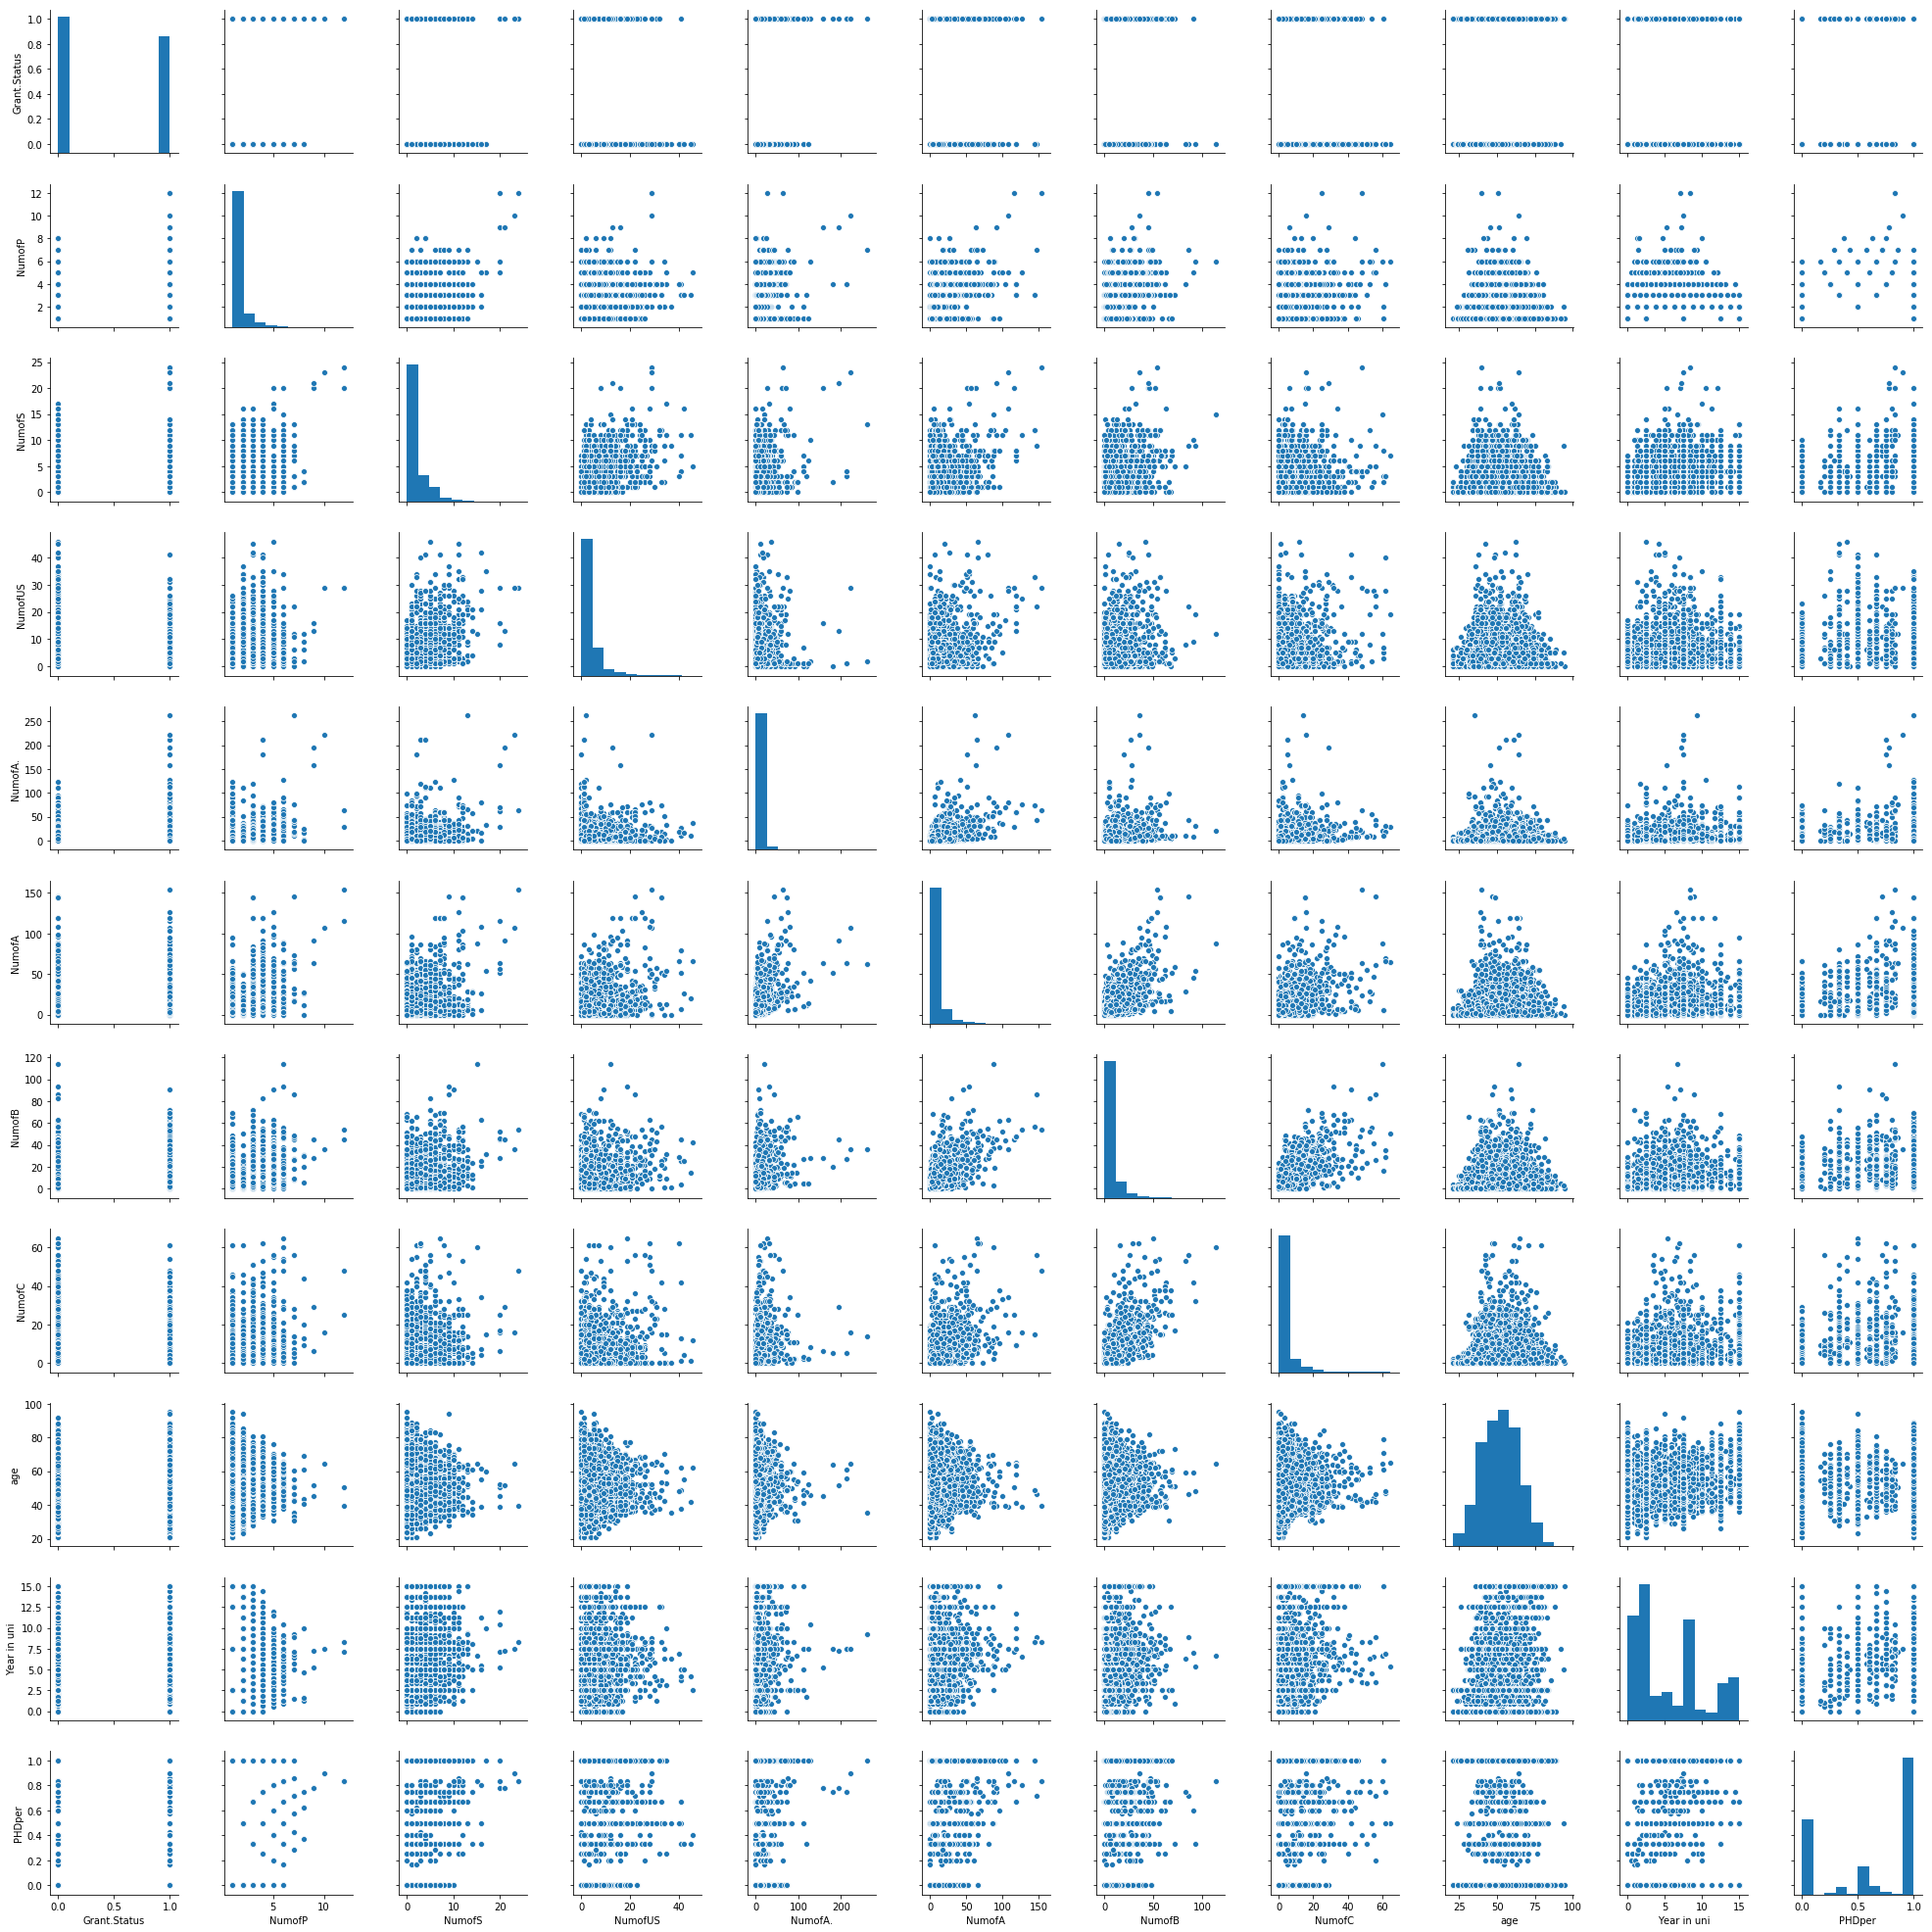

In [67]:
sns.pairplot(application, size=2.5)
plt.tight_layout()
plt.show()

检查样本是否平衡

In [26]:
application['Grant.Status'].value_counts()

0    4215
1    3615
Name: Grant.Status, dtype: int64

## 逻辑回归

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(application[application.columns.difference(['Grant.Status'])], application['Grant.Status'], test_size=0.33, random_state=42)

pipe_lr = make_pipeline(StandardScaler(),LogisticRegression())
pipe_lr.fit(X_train, y_train)

print(classification_report(y_test, pipe_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1389
           1       0.74      0.69      0.71      1195

   micro avg       0.74      0.74      0.74      2584
   macro avg       0.74      0.74      0.74      2584
weighted avg       0.74      0.74      0.74      2584



C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [46]:
pd.DataFrame(data={'feature':list(application.columns.difference(['Grant.Status'])),'coef':list(pipe_lr.named_steps['logisticregression'].coef_[0])})

,feature,coef
0,NumofA,0.079495
1,NumofA.,0.009757
2,NumofB,0.152322
3,NumofC,-0.087445
4,NumofP,-0.036280
5,NumofS,0.964162
6,NumofUS,-1.448681
7,PHDper,0.088244
8,Year in uni,0.074347
9,age,-0.018292


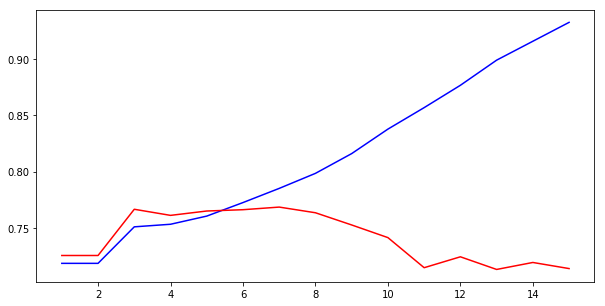

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
X_train, X_test, y_train, y_test = train_test_split(application[application.columns.difference(['Grant.Status'])], application['Grant.Status'], test_size=0.33, random_state=42)
errt=[]
erra=[]
for n in range(1,16):
    pipe_dt = make_pipeline(DecisionTreeClassifier(max_depth=n))
    pipe_dt.fit(X_train, y_train)
    errt.append(accuracy_score(y_test,pipe_dt.predict(X_test)))
    erra.append(accuracy_score(y_train,pipe_dt.predict(X_train)))
    
plt.figure(figsize=(10,5))
plt.plot(range(1,16),erra,color='b')
plt.plot(range(1,16),errt,color='r')
plt.show()

In [75]:
from sklearn.ensemble import AdaBoostClassifier

errt=[]
erra=[]
for n in range(1,100):
    pipe_ada = make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=n, random_state=0))
    pipe_ada.fit(X_train, y_train)
    errt.append(accuracy_score(y_test,pipe_ada.predict(X_test)))
    erra.append(accuracy_score(y_train,pipe_ada.predict(X_train)))


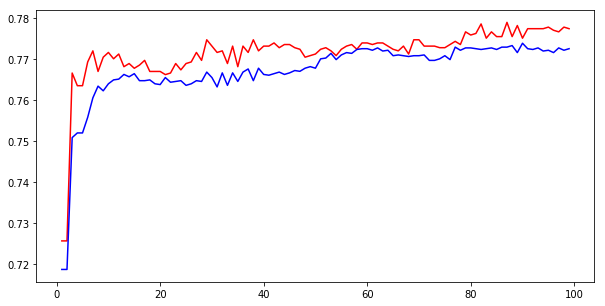

In [76]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100),errt,color='r')
plt.plot(range(1,100),erra,color='b')
plt.show()

## 随机森林

In [77]:
from sklearn.ensemble import RandomForestClassifier
errt=[]
erra=[]
for n in range(1,100):
    pipe_rd = make_pipeline(RandomForestClassifier(n_estimators=n,max_depth=2))
    pipe_rd.fit(X_train, y_train)
    errt.append(accuracy_score(y_test,pipe_rd.predict(X_test)))
    erra.append(accuracy_score(y_train,pipe_rd.predict(X_train)))

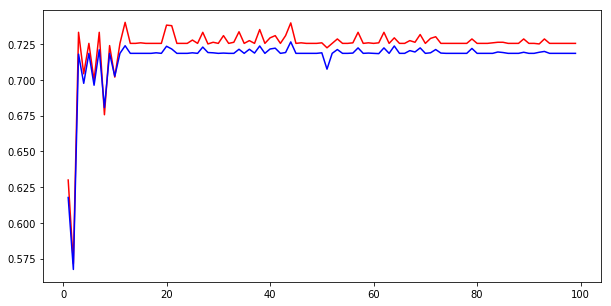

In [78]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100),errt,color='r')
plt.plot(range(1,100),erra,color='b')
plt.show()

预测准确率保持在约0.725